# Indicator of heavy rainfall

## SPI approach

The SPI can also be used as an indicator of heavy rainfall periods (REF)

The choice of time period over which to calculate SPI is still open.



## Return value approach

> Previous editions looked at the 10-year return value for (daily?) rainfall. Doing this would mean getting daily data from ERA which is a pain. Possibly this could be done monthly instead. In the end it's not that dissimilar to SPI threshold (calculating how likely the event it)


In [1]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numba
import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs
from scipy import stats

import weather_ecmwf
import population_tools

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

In [2]:

MAX_YEAR = 2017

POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'

RESULTS_FOLDER = Path('./results/lancet2018/global/1.5 extreme rain')
EXTREME_RAIN_THRESHOLD = 1.64


In [20]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:58571 Dashboard: http://127.0.0.1:58572/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [5]:
cru_spi6 = xr.open_dataarray(DATA_SRC / 'lancet' / 'spi6_1901_2016_cru.nc', 
                             chunks={'time': 12}
                            )

In [6]:
very_wet_events = cru_spi6.where(cru_spi6 > EXTREME_RAIN_THRESHOLD)

In [7]:
event_counts = very_wet_events.groupby('time.year').count(dim='time').astype(float)

## Map the heavy rain event counts

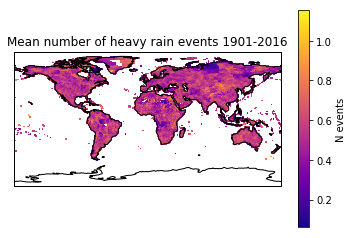

In [8]:
event_counts_mean = event_counts.mean(dim='year')
event_counts_mean = event_counts_mean.where(event_counts_mean > 0)
event_counts_mean.name = 'N events'
# drought_counts_mean.plot()

f = plt.figure()
ax = plt.subplot(projection=crs.PlateCarree())
p = event_counts_mean.plot.pcolormesh(
    cmap='plasma',
    transform=crs.PlateCarree()
)
ax.coastlines()
plt.title('Mean number of heavy rain events 1901-2016')

plt.savefig(RESULTS_FOLDER / 'mean n events 1901-2016 map.png', 
            bbox_inches='tight', dpi=300)

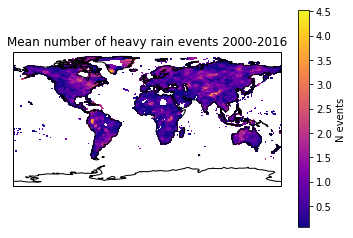

In [9]:
event_counts_mean = event_counts.sel(year=slice(2000, 2017)).mean(dim='year')
event_counts_mean = event_counts_mean.where(event_counts_mean > 0)
event_counts_mean.name = 'N events'
# drought_counts_mean.plot()

f = plt.figure()
ax = plt.subplot(projection=crs.PlateCarree())
p = event_counts_mean.plot.pcolormesh(
    cmap='plasma',
    transform=crs.PlateCarree()
)
ax.coastlines()
plt.title('Mean number of heavy rain events 2000-2016')

plt.savefig(RESULTS_FOLDER / 'mean n events 2000-2016 map.png', 
            bbox_inches='tight', dpi=300)

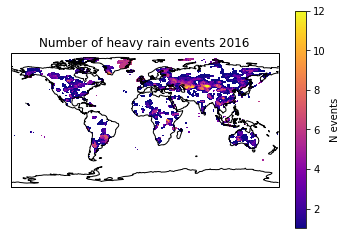

In [10]:
event_counts_mean = event_counts.sel(year=2016)
event_counts_mean = event_counts_mean.where(event_counts_mean > 0)
event_counts_mean.name = 'N events'

f = plt.figure()
ax = plt.subplot(projection=crs.PlateCarree())
p = event_counts_mean.plot.pcolormesh(
    cmap='plasma',
    transform=crs.PlateCarree()
)
ax.coastlines()
plt.title('Number of heavy rain events 2016')

plt.savefig(RESULTS_FOLDER / 'n events 2016 map.png', 
            bbox_inches='tight', dpi=300)

## Express global trend as 'area at risk of flooding'

In [11]:
# Calculate grid cell areas
delta_lon = cru_spi6.lon[1] - cru_spi6.lon[0]
earth_radius = 6371

areas = (np.sin(np.radians(cru_spi6.lat.values + 0.25))
 - np.sin(np.radians(cru_spi6.lat.values - 0.25))) * (np.radians(delta_lon.values)) * earth_radius**2

In [12]:
# NOTE: it's not really in flood, just at risk
in_flood = cru_spi6 > EXTREME_RAIN_THRESHOLD
in_flood = in_flood.astype(int)

in_flood['areas'] = xr.DataArray(areas, dims=['lat'], coords={'lat': cru_spi6.lat})
in_flood = in_flood * in_flood.areas

In [13]:
flood_area_ts = in_flood.sum(dim=['lat', 'lon']).compute()
flood_area_ts.name = 'Area of heavy rain (million km2)'

In [14]:
flood_area_ts.to_dataframe().to_excel(RESULTS_FOLDER / 'area_in_flood_spi6.xlsx')

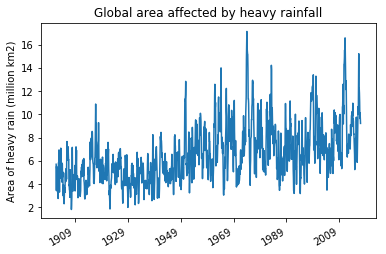

In [15]:
(flood_area_ts[12:] / 1_000_000).plot()
plt.title('Global area affected by heavy rainfall')
plt.xlabel('')
plt.savefig(RESULTS_FOLDER / 'area_in_flood_spi6.png', dpi=300)

## Project heavy rainfall to population to get the exposure indicator

In [16]:
# Convert the drought data from -180 to 180 => 0 to 360
event_counts = event_counts.roll(lon=len(event_counts.lon)//2)

lons = event_counts['lon'].values
lons[lons <0 ] += 360
event_counts['lon'] = lons

In [17]:
event_count_projected_ts = population_tools.project_to_population(event_counts,
                                                              norm=False, get_ts=True)


event_count_projected_ts = event_count_projected_ts.compute()

In [18]:
event_count_projected_ts.to_dataframe('drough exposures').to_excel(RESULTS_FOLDER / 'flood exposures.xlsx')

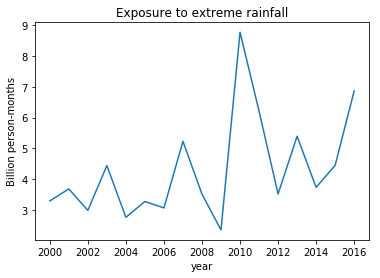

In [19]:
(event_count_projected_ts / 1_000_000_000).plot()
plt.ylabel('Billion person-months')
plt.title('Exposure to extreme rainfall')
plt.savefig(RESULTS_FOLDER / 'flood exposure.png', dpi=300)

# Daily rainfall approach - reproduce 2015 method

> Watts et. al 2015: Figure 7 shows estimates of extreme precipitation events (events exceeding 10 year return period) under the RCP8.5 (high-emission) scenario. We estimate that there would be around 2 billion additional extreme rainfall exposure events annually (individuals exposed once or multiple times during any year). Flood risk was estimated by defining a flood event to be a 5 day precipitation total exceeding the 10 year return level in the hisotircal period (1986-2005).


In [3]:
ppt_5day = xr.open_mfdataset(str(WEATHER_SRC / 'ecmwf' / '5day_precipitation'/ '*_ppt_5day.nc'), 
#                               chunks={'latitude': 100, 'longitude': 100}
                            )

In [4]:
from numba import jit, prange, float32

In [5]:
@jit(nopython=True, nogil=True)
def return_threshold_10_year(rain_ts):
    out = np.zeros((rain_ts.shape[0], rain_ts.shape[1]), dtype=np.float32)
    for i in range(rain_ts.shape[0]):
        for j in range(rain_ts.shape[1]):
            ts = rain_ts[i, j, :]
            ts = np.sort(ts[np.isfinite(ts)])
            N = len(ts)
            
            rank = np.arange(N) + 1
            #Gringorten 
            gringorten_dist = (rank - 0.44) / (N + 0.12)
            T = 1 / (1 - gringorten_dist)
            p = ts[T >= 10]
            out[i, j] = p.min()
    return out

In [8]:
def _get_ten_year_return(ppt_5day):
    ppt_baseline = ppt_5day.precipitation.sel(time=slice('1986-01-01','2008-12-31'))
    ppt_baseline = ppt_baseline.load()
    ppt_baseline = ppt_baseline.chunk(chunks={'latitude': 20, 'longitude': 20, 'time': -1})
    return xr.apply_ufunc(return_threshold_10_year,
                               ppt_baseline,
                               input_core_dims=[['time']],
                               output_core_dims=[[]],
                               dask='parallelized',
                               output_dtypes=[np.float64]
                               )
        
ten_yr_retn = _get_ten_year_return(ppt_5day).compute()

In [10]:
ten_yr_retn.to_netcdf(DATA_SRC / 'lancet' / 'ten_year_ppt_return.nc')

In [169]:
ppt_5day = ppt_5day.precipitation.sel(time=slice('2000-01-01',None))

## Calculate events


Merge high rainfall events that occur on consecutive days, since these are really just one event

In [14]:
@jit("int64[:,:](b1[:,:,:])")
def fast_event_counts(events):
    
    last_slice = None
    accumulator = np.zeros(events.shape[1:], dtype=np.int64)
    counter = np.zeros(events.shape[1:], dtype=np.int64)
    
    for i in range(1, events.shape[0]):
        last_slice = events[i-1, :, :]
        data_slice = events[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add one to the counter where the sequences are ending
        counter[mask] += 1
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return counter



In [12]:
events = ppt_5day.precipitation > ten_yr_retn
events.name = 'precipitation_events'

In [203]:
events = events.compute()

In [15]:
def _fn(events_grp):
    counter = fast_event_counts(events_grp.values)
    return xr.DataArray(counter,
                        coords=[events.latitude.values,
                                events.longitude.values], 
                           dims=['latitude', 'longitude'],
                           name='event_count'
                          )

event_counts = events.groupby('time.year').apply(_fn, shortcut=True)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


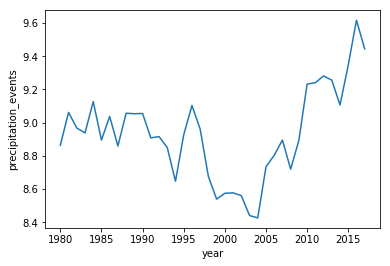

In [17]:
# Mean number of events over time (not weighted for area)
event_counts.mean(dim=['latitude', 'longitude']).plot()

## Express global trend as 'events per km2' (map) and 'area affected by extreme rain'


In [75]:
# Calculate grid cell areas
delta_lon = events.longitude[1] - events.longitude[0]
earth_radius = 6371

areas = (np.sin(np.radians(events.latitude.values + delta_lon.values/2))
 - np.sin(np.radians(events.latitude.values - delta_lon.values/2))) * (np.radians(delta_lon.values)) * earth_radius**2

areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': events.latitude})


In [76]:
event_area_ts = (events * areas).sum(dim=['latitude', 'longitude']).compute()

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [82]:
event_area_ts[event_area_ts.time.dt.dayofyear > 5]

<xarray.DataArray (time: 13690)>
array([ 43634666.129593,  45882599.065628,  47123856.011411, ...,
        49135480.827226,  47383988.495429,  46265495.362039])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-06 1980-01-07 1980-01-08 ...

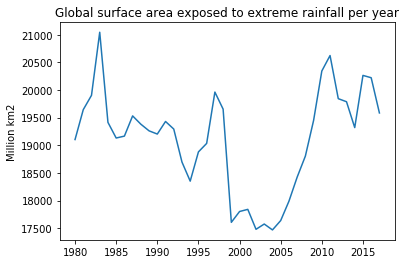

In [88]:
# (event_area_ts.rolling(time=30).mean(dim='time')/ 1_000_000).plot()
(event_area_ts.groupby('time.year').sum(dim='time')/ 1_000_000).plot()

# (event_area_ts[event_area_ts.time.dt.dayofyear > 5]/ 1_000_000).plot()
plt.title('Global surface area exposed to extreme rainfall per year')
plt.xlabel('')
plt.ylabel('Million km2')

plt.savefig(RESULTS_FOLDER / 'area_extreme_rainfall_ts.png', dpi=300)

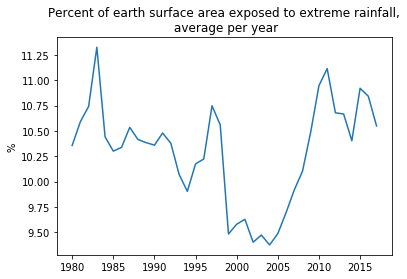

In [94]:
d = 100*event_area_ts[event_area_ts.time.dt.dayofyear > 5] / (510.1 * 1e6)
d.groupby('time.year').mean(dim='time').plot()

plt.title('Percent of earth surface area exposed to extreme rainfall,\n average per year')
plt.xlabel('')
plt.ylabel('%')

plt.savefig(RESULTS_FOLDER / 'pct_area_extreme_rainfall_ts.png', dpi=300)

In [22]:
events.to_netcdf(DATA_SRC / 'lancet' / 'ppt_ten_year_events.nc')

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [ ]:
import geopandas as gpd
# COUNTRY_POLY_SHP
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

COUNTRIES['dummy'] = 1

land_raster = population_tools.rasterize_data(spi6, COUNTRIES, 'dummy')

Text(0.5,1,'Number of extreme rainfall events, 2017')

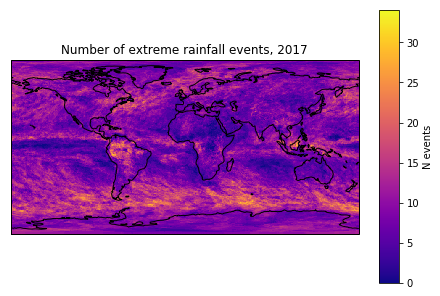

In [103]:
event_counts_mean = event_counts.sel(year=2017)
# event_counts_mean = event_counts_mean.where(event_counts_mean > 0)
event_counts_mean.name = 'N events'

f = plt.figure(constrained_layout=True)
ax = plt.subplot(projection=crs.PlateCarree())
p = event_counts_mean.plot.pcolormesh(
    cmap='plasma',
    transform=crs.PlateCarree()
)
ax.coastlines()
plt.title('Number of extreme rainfall events, 2017')

# plt.savefig(RESULTS_FOLDER / 'n events 2016 map.png', 
#             bbox_inches='tight', dpi=300)

## Calculate change in yearly event counts relative to 1986-2008 average

In [23]:
event_counts_change = event_counts.sel(year=slice(2000,None)) - event_counts.sel(year=slice(1986,2008)).mean(dim='year')

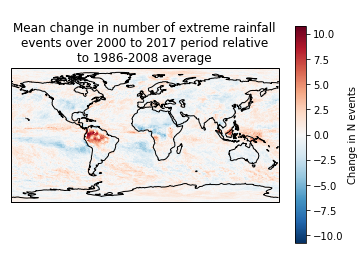

In [66]:
data = event_counts_change.mean(dim='year')
data.name = 'Change in N events'

f = plt.figure()
ax = plt.subplot(projection=crs.PlateCarree())
p = data.plot.pcolormesh(
    transform=crs.PlateCarree()
)
ax.coastlines()
plt.title('''
Mean change in number of extreme rainfall
events over 2000 to 2017 period relative
to 1986-2008 average''')

plt.savefig(RESULTS_FOLDER / 'mean events change 2000-2017 map.png', 
            bbox_inches='tight', dpi=600)

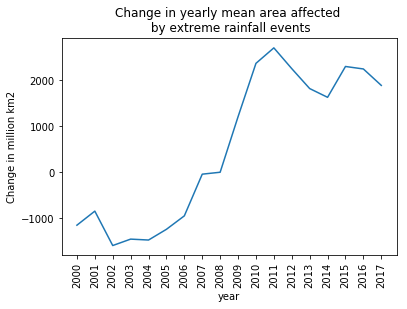

In [63]:
(event_counts_change * areas).mean(dim=['latitude', 'longitude']).plot()
plt.xticks(event_counts_change['year'], rotation=90)
plt.ylabel('Change in million km2')
plt.title('Change in yearly mean area affected \n by extreme rainfall events')
plt.savefig(RESULTS_FOLDER / 'area_events_ts.png', bbox_inches='tight', dpi=300)

In [27]:
exposure_change_ts = population_tools.project_to_population(event_counts_change, get_ts=True).compute()

In [52]:
exposure_change_ts.to_dataframe('exposures').to_excel(RESULTS_FOLDER / 'exposures_change.xlsx')

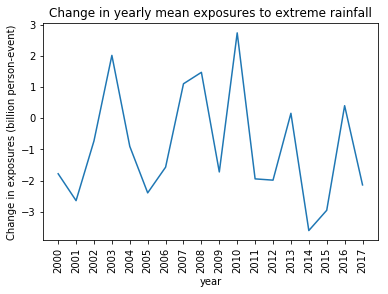

In [74]:
(exposure_change_ts/ 1e9).plot()
plt.xticks(exposure_change_ts['year'], rotation=90)
plt.ylabel('Change in exposures (billion person-event)')
plt.title('Change in yearly mean exposures to extreme rainfall')
plt.savefig(RESULTS_FOLDER / 'exposures_change_ts.png', bbox_inches='tight', dpi=300)

## Absolute number of exposures

> NOTE not sure whether to look at change or absolute, because we already take regional variation into account when we calculate the return value so does it make sense to again look at the mean number of events? Note also that because we coalesce events might have fewer events that area really long -> not actually better than having many small events.

In [67]:
event_counts = event_counts.astype(np.float64)
exposures_ts = population_tools.project_to_population(event_counts, get_ts=True).compute()

In [289]:
delta_lon = exposures_ts.longitude[1] - events_projected.longitude[0]
earth_radius = 6371

areas_proj = (np.sin(np.radians(events_projected.latitude.values + delta_lon.values/2))
 - np.sin(np.radians(events_projected.latitude.values - delta_lon.values/2))) * (np.radians(delta_lon.values)) * earth_radius**2

areas_proj = xr.DataArray(areas_proj, 
                          dims=['latitude'], 
                          coords={'latitude': events_projected.latitude})


In [71]:
exposures_ts.to_dataframe('exposures').to_excel(RESULTS_FOLDER / 'exposures.xlsx')

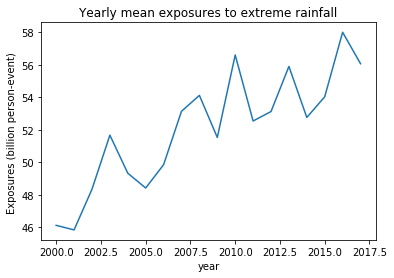

In [73]:
(exposures_ts / 1e9).plot()
plt.title('Yearly mean exposures to extreme rainfall')
plt.ylabel('Exposures (billion person-event) ')
plt.savefig(RESULTS_FOLDER / 'exposures_ts.png', bbox_inches='tight', dpi=300)

### Rank order method to calculate return values

In [36]:
N = len(test_ts)
ts_sorted = np.sort(test_ts)
rank = np.array(range(N)) + 1
#Gringorten 
gringorten_dist = (rank - 0.44) / (N + 0.12)

In [39]:
df = pd.DataFrame({'rank':rank, 'rain':ts_sorted, 'prob': gringorten_dist})

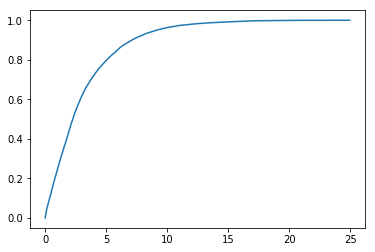

In [41]:
plt.plot(df.rain, df.prob)

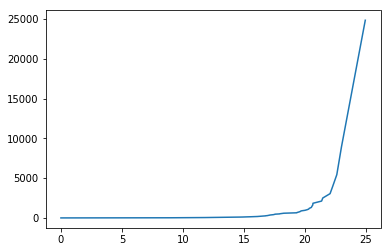

In [44]:
T = 1 / (1 - df.prob)

plt.plot(df.rain, T)